In [3]:
import json

with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
class Dataset_Reader(Dataset):
    def __init__(self, data):
        self.data = data

        self.texts = []
        self.labels = []
        for idx, document in enumerate(data):
            current_id = document['id']
            # current_meta = document['meta']['group']
            for annotation in document['annotations']:
                for sentence in annotation['result']:
                    text = sentence['value']['text'].lower().replace('\n', '')
                    label = sentence['value']['labels'][0]

                    self.texts.append(text)
                    self.labels.append(label)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'label': self.labels[idx],
        }

In [6]:
data_train = Dataset_Reader(train_data)
data_test = Dataset_Reader(test_data)

In [11]:
for idx, label in enumerate(data_train.labels):
    if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
        data_train.labels[idx] = "ARG"
    elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
        data_train.labels[idx] = 'PRE'
for idx, label in enumerate(data_test.labels):
    if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
        data_train.labels[idx] = "ARG"
    elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
        data_train.labels[idx] = 'PRE'

In [12]:
dataset_size = len(data_train)
val_size = int(dataset_size * 0.1)
train_size = dataset_size - val_size
train_set, val_set = torch.utils.data.random_split(data_train, [train_size, val_size])
train_set.augment = True


batch_size = 8
train_dataloader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(val_set,batch_size=batch_size)

print(len(train_dataloader))
print(len(val_dataloader))


3261
363


In [13]:
list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder1 = LabelEncoder().fit(list_of_targets)
list_of_targets = list(set(data_train.labels))
label_encoder = LabelEncoder().fit(list_of_targets)

In [14]:
len(label_encoder1.classes_)

13

In [15]:
len(label_encoder.classes_)

11

In [155]:
def remap_targets(target_tensor: torch.TensorType, old_le, new_le):
    inverse_tensor = old_le.inverse_transform(target_tensor.long())
    for idx, label in enumerate(inverse_tensor):
        if label == 'ARG_RESPONDENT' or label == 'ARG_PETITIONER':
            inverse_tensor[idx] = "ARG"
        elif label == 'PRE_NOT_RELIED' or label == 'PRE_RELIED':
            inverse_tensor[idx] = 'PRE'
    new_tensor = torch.tensor(new_le.transform(inverse_tensor))
    return new_tensor

In [18]:
from transformers import BertTokenizer, BertModel

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
class Bert(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dense = nn.Sequential(nn.Linear(in_features= 768, out_features=256),
                                   nn.ReLU(),
                                   nn.Linear(in_features= 256, out_features= 13),
                                   nn.Softmax(dim=1))
        
    def forward(self, x):
        out = self.bert(**x).pooler_output
        out = self.dense(out)
        return out

In [30]:
model = Bert()
loss_function = nn.CrossEntropyLoss()
model_opt = torch.optim.AdamW(params= model.parameters(), lr= 2e-5)

In [29]:
from tqdm import tqdm

In [31]:
i = 0
loss_list = []
for batch in tqdm(train_dataloader):
    i+=1
    input = batch['text']
    target = batch['label']
    target_pt = torch.tensor(label_encoder.transform(target))
    tokenized_inputs = tokenizer(input,truncation= True,
                                 padding = 'max_length', max_length= 128,
                                 return_tensors= 'pt',return_token_type_ids= False)
    output = model.forward(tokenized_inputs)
    loss = loss_function(output, target_pt)
    
    model.zero_grad()
    loss.backward()
    model_opt.step()
    
    loss_list.append(loss.item())
    if i % 10 == 0:
        print(f"{i} \t {loss.item()}")

  0%|          | 10/3261 [01:13<6:09:01,  6.81s/it]

10 	 2.544177770614624


  1%|          | 20/3261 [02:23<6:30:20,  7.23s/it]

20 	 2.4996516704559326


  1%|          | 30/3261 [03:30<5:51:42,  6.53s/it]

30 	 2.479682445526123


  1%|          | 31/3261 [03:43<6:28:23,  7.21s/it]


KeyboardInterrupt: 

In [19]:
import os, sys

import torch
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import load_tensor

In [182]:
sample_input, sample_target = None, None
for idx in range(246):
    if sample_input is None:
        sample_input = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        sample_target = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    else:
        sample_input = torch.cat((sample_input,load_tensor(filepath=f"../train_document/doc_{idx}/embedding")), dim=0)
        sample_target = torch.cat((sample_target,load_tensor(filepath=f"../train_document/doc_{idx}/label")), dim=0)

In [183]:
# sample_input, sample_target = None, None
# for idx in range(29):
#     if sample_input is None:
#         sample_input = load_tensor(filepath=f"../test_document/doc_{idx}/embedding")
#         sample_target = load_tensor(filepath=f"../test_document/doc_{idx}/label")
#     else:
#         sample_input = torch.cat((sample_input,load_tensor(filepath=f"../test_document/doc_{idx}/embedding")), dim=0)
#         sample_target = torch.cat((sample_target,load_tensor(filepath=f"../test_document/doc_{idx}/label")), dim=0)

In [24]:
import numpy as np

def uniform_sample(input_tensor, target_tensor, num_classes):
    class_indices = [np.where(target_tensor.numpy() == i)[0] for i in range(num_classes)]
    min_class_samples = min(len(indices) for indices in class_indices)
    print([len(indices) for indices in class_indices]) 
    print(min_class_samples)
    sampled_indices = []
    for indices in class_indices:
        sampled_indices.extend(np.random.choice(indices, min_class_samples, replace=False))
    
    sampled_indices = np.random.permutation(sampled_indices)
    # print(sampled_indices)
    
    return input_tensor[sampled_indices], target_tensor[sampled_indices]

In [140]:
sample_input.size()

torch.Size([28864, 1, 768])

In [141]:
sample_target.size()

torch.Size([28864])

In [142]:
x, y = uniform_sample(sample_input, sample_target, 13)

[10667, 1315, 687, 5724, 367, 1415, 4134, 158, 1419, 673, 749, 1078, 478]
158


In [156]:
label_encoder1.inverse_transform(sample_target.long())

array(['PREAMBLE', 'PREAMBLE', 'PREAMBLE', ..., 'RPC', 'RPC', 'NONE'],
      dtype='<U14')

In [157]:
remapped_target = remap_targets(sample_target, label_encoder1, label_encoder)

In [158]:
x, y = uniform_sample(sample_input, remapped_target,11)

[10667, 2002, 5724, 367, 1415, 1577, 4134, 673, 749, 1078, 478]
367


## Training with new classes


In [32]:
from evaluation import *
from tqdm import tqdm
from itertools import product

In [33]:
def get_accuracy_value(item):
    return item[1][0]

def grid_search(parameters):
    keys = parameters.keys()
    values = parameters.values()
    
    combinations = list(product(*values))
    
    parameter_configurations = [{k: v for k, v in zip(keys, combination)} for combination in combinations]
    
    return parameter_configurations

In [34]:
def calculate_confusion_matrix(test_emb, test_labels, model, num_labels):
    model.eval()
    output = model(test_emb)
    return confusion_matrix(output, test_labels, num_labels)

In [35]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size*2, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1))
        
        self.apply(init_weights)
        
    def forward(self, x):
        x = x.permute(1,0,2)
        lstm_out, _ = self.bilstm(x.squeeze(0))

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [162]:
def grid_search_train_test(parameters):
    result = []
    
    parameter_configs = grid_search(parameters)
    for config in parameter_configs:
        loss_list = []
        running_lr = []
        model = BiLSTM(hidden_size=config['hidden_size'], num_layers=config['num_layers'], dropout=config['dropout'], output_size= 11)
        model_opt = torch.optim.Adam(model.parameters(), lr= config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model_opt, T_max= config['epochs'], eta_min= config['learning_rate_floor'])
        scheduler1 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.8, total_iters= config['epochs']*0.4)
        scheduler2 = torch.optim.lr_scheduler.ConstantLR(model_opt, factor= 0.6, total_iters= config['epochs']*0.7)
        loss_function = nn.CrossEntropyLoss()
        print("Working with: ")
        print(config)
        print(f'{"Starting Training":-^100}')
        model.train()
        for epoch in tqdm(range(config['epochs'])):
            running_loss = []
            for idx in range(246):
                TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
                TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
                TRAIN_labels = remap_targets(TRAIN_labels, label_encoder1, label_encoder)
                if TRAIN_emb.size(0) == 0:
                    continue
                output = model(TRAIN_emb)
                loss = loss_function(output,TRAIN_labels)
                
                model_opt.zero_grad()
                loss.backward()
                model_opt.step()
                running_loss.append(loss.item())
            scheduler.step()
            scheduler1.step()
            scheduler2.step()
            running_lr.append(model_opt.state_dict()['param_groups'][0]['lr'])
            loss_list.append(np.mean(running_loss))
            print(f"Epoch: {epoch+1} \t Loss: {np.mean(running_loss):.5f} \t LR: {model_opt.state_dict()['param_groups'][0]['lr']}")
        # batch_loss.append(loss.item())
        cm = None
        for i in range(29):
            TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
            TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
            TEST_labels = remap_targets(TEST_labels, label_encoder1, label_encoder)
            conf_matrix_helper = calculate_confusion_matrix(TEST_emb, TEST_labels, model, num_labels= 11)
            if cm is None:
                cm = conf_matrix_helper
            else:
                cm = np.add(cm, conf_matrix_helper)
                
        accuracies = class_accuracy(cm)
        f1_scores = class_f1_score(cm)
        average_accuracy = np.mean(accuracies)
        average_f1 = np.mean(f1_scores)

        print("Accuracies: {} \n Average acccuracy: {}".format(accuracies, average_accuracy))
        print("F1 Scores: {} \n Average F1: {}".format(f1_scores, average_f1))
        result.append((config, (average_accuracy, average_f1)))
    return cm, loss_list, result, running_lr

In [163]:
parameter_configs = {
    'epochs': [200],
    'learning_rate': [5e-4],
    'learning_rate_floor': [5e-6],
    'dropout': [0.25],
    'hidden_size': [256],
    'num_layers': [1]
    }

cm, loss_list, result, lrs = grid_search_train_test(parameter_configs)

max_accuracy_config = max(result, key=get_accuracy_value)

print(max_accuracy_config)

Working with: 
{'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}
-----------------------------------------Starting Training------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 1/200 [00:25<1:25:03, 25.65s/it]

Epoch: 1 	 Loss: 2.18306 	 LR: 0.00023998550431659512


  1%|          | 2/200 [00:48<1:18:47, 23.88s/it]

Epoch: 2 	 Loss: 2.00981 	 LR: 0.00023994202084297347


  2%|▏         | 3/200 [01:11<1:17:57, 23.75s/it]

Epoch: 3 	 Loss: 1.97913 	 LR: 0.0002398695603080315


  2%|▏         | 4/200 [01:33<1:15:06, 22.99s/it]

Epoch: 4 	 Loss: 1.94971 	 LR: 0.00023976814059032192


  2%|▎         | 5/200 [01:55<1:13:34, 22.64s/it]

Epoch: 5 	 Loss: 1.91760 	 LR: 0.00023963778671364254


  3%|▎         | 6/200 [02:16<1:11:13, 22.03s/it]

Epoch: 6 	 Loss: 1.87074 	 LR: 0.00023947853084086188


  4%|▎         | 7/200 [02:36<1:08:33, 21.31s/it]

Epoch: 7 	 Loss: 1.86182 	 LR: 0.0002392904122659836


  4%|▍         | 8/200 [02:57<1:08:06, 21.28s/it]

Epoch: 8 	 Loss: 1.87135 	 LR: 0.00023907347740445114


  4%|▍         | 9/200 [03:17<1:06:06, 20.77s/it]

Epoch: 9 	 Loss: 1.85861 	 LR: 0.00023882777978169548


  5%|▌         | 10/200 [03:40<1:07:43, 21.39s/it]

Epoch: 10 	 Loss: 1.83350 	 LR: 0.00023855338001992866


  6%|▌         | 11/200 [04:02<1:07:59, 21.58s/it]

Epoch: 11 	 Loss: 1.84279 	 LR: 0.0002382503458231859


  6%|▌         | 12/200 [04:24<1:08:32, 21.88s/it]

Epoch: 12 	 Loss: 1.82971 	 LR: 0.00023791875196062088


  6%|▋         | 13/200 [04:45<1:07:38, 21.70s/it]

Epoch: 13 	 Loss: 1.82034 	 LR: 0.00023755868024805742


  7%|▋         | 14/200 [05:09<1:09:08, 22.30s/it]

Epoch: 14 	 Loss: 1.81798 	 LR: 0.0002371702195278028


  8%|▊         | 15/200 [05:30<1:07:29, 21.89s/it]

Epoch: 15 	 Loss: 1.82761 	 LR: 0.00023675346564672696


  8%|▊         | 16/200 [05:52<1:07:09, 21.90s/it]

Epoch: 16 	 Loss: 1.81922 	 LR: 0.00023630852143261412


  8%|▊         | 17/200 [06:12<1:05:24, 21.45s/it]

Epoch: 17 	 Loss: 1.81666 	 LR: 0.00023583549666879124


  9%|▉         | 18/200 [06:34<1:04:58, 21.42s/it]

Epoch: 18 	 Loss: 1.81142 	 LR: 0.00023533450806704077


 10%|▉         | 19/200 [06:53<1:03:03, 20.90s/it]

Epoch: 19 	 Loss: 1.80665 	 LR: 0.00023480567923880372


 10%|█         | 20/200 [07:17<1:04:54, 21.63s/it]

Epoch: 20 	 Loss: 1.80310 	 LR: 0.0002342491406646805


 10%|█         | 21/200 [07:37<1:03:30, 21.29s/it]

Epoch: 21 	 Loss: 1.80118 	 LR: 0.00023366502966223651


 11%|█         | 22/200 [08:00<1:04:39, 21.80s/it]

Epoch: 22 	 Loss: 1.80149 	 LR: 0.00023305349035212142


 12%|█▏        | 23/200 [08:22<1:03:54, 21.66s/it]

Epoch: 23 	 Loss: 1.79871 	 LR: 0.00023241467362250935


 12%|█▏        | 24/200 [08:44<1:04:08, 21.87s/it]

Epoch: 24 	 Loss: 1.80211 	 LR: 0.00023174873709186946


 12%|█▎        | 25/200 [09:06<1:03:37, 21.81s/it]

Epoch: 25 	 Loss: 1.80387 	 LR: 0.00023105584507007612


 13%|█▎        | 26/200 [09:26<1:01:47, 21.31s/it]

Epoch: 26 	 Loss: 1.79936 	 LR: 0.0002303361685178677


 14%|█▎        | 27/200 [09:48<1:02:35, 21.71s/it]

Epoch: 27 	 Loss: 1.79603 	 LR: 0.00022958988500466473


 14%|█▍        | 28/200 [10:10<1:02:04, 21.66s/it]

Epoch: 28 	 Loss: 1.79292 	 LR: 0.00022881717866475723


 14%|█▍        | 29/200 [10:32<1:02:26, 21.91s/it]

Epoch: 29 	 Loss: 1.79904 	 LR: 0.00022801824015187226


 15%|█▌        | 30/200 [10:54<1:01:32, 21.72s/it]

Epoch: 30 	 Loss: 1.79324 	 LR: 0.00022719326659213315


 16%|█▌        | 31/200 [11:13<59:32, 21.14s/it]  

Epoch: 31 	 Loss: 1.78950 	 LR: 0.00022634246153542144


 16%|█▌        | 32/200 [11:33<57:59, 20.71s/it]

Epoch: 32 	 Loss: 1.78946 	 LR: 0.0002254660349051539


 16%|█▋        | 33/200 [11:55<58:14, 20.93s/it]

Epoch: 33 	 Loss: 1.78590 	 LR: 0.0002245642029464874


 17%|█▋        | 34/200 [12:15<57:38, 20.84s/it]

Epoch: 34 	 Loss: 1.78091 	 LR: 0.00022363718817296332


 18%|█▊        | 35/200 [12:36<57:28, 20.90s/it]

Epoch: 35 	 Loss: 1.77467 	 LR: 0.0002226852193116058


 18%|█▊        | 36/200 [12:57<57:16, 20.95s/it]

Epoch: 36 	 Loss: 1.77604 	 LR: 0.00022170853124648673


 18%|█▊        | 37/200 [13:18<56:25, 20.77s/it]

Epoch: 37 	 Loss: 1.76927 	 LR: 0.00022070736496077173


 19%|█▉        | 38/200 [13:41<58:30, 21.67s/it]

Epoch: 38 	 Loss: 1.76272 	 LR: 0.00021968196747726096


 20%|█▉        | 39/200 [14:02<56:58, 21.23s/it]

Epoch: 39 	 Loss: 1.75716 	 LR: 0.0002186325917974402


 20%|██        | 40/200 [14:23<56:24, 21.15s/it]

Epoch: 40 	 Loss: 1.75471 	 LR: 0.0002175594968390563


 20%|██        | 41/200 [14:43<55:46, 21.05s/it]

Epoch: 41 	 Loss: 1.74936 	 LR: 0.00021646294737223313


 21%|██        | 42/200 [15:04<54:45, 20.80s/it]

Epoch: 42 	 Loss: 1.74995 	 LR: 0.00021534321395414357


 22%|██▏       | 43/200 [15:24<53:53, 20.60s/it]

Epoch: 43 	 Loss: 1.74259 	 LR: 0.00021420057286225373


 22%|██▏       | 44/200 [15:44<53:37, 20.62s/it]

Epoch: 44 	 Loss: 1.73875 	 LR: 0.00021303530602615522


 22%|██▎       | 45/200 [16:06<53:45, 20.81s/it]

Epoch: 45 	 Loss: 1.73852 	 LR: 0.00021184770095800364


 23%|██▎       | 46/200 [16:26<53:21, 20.79s/it]

Epoch: 46 	 Loss: 1.74370 	 LR: 0.000210638050681579


 24%|██▎       | 47/200 [16:47<52:37, 20.63s/it]

Epoch: 47 	 Loss: 1.73888 	 LR: 0.0002094066536599866


 24%|██▍       | 48/200 [17:07<51:55, 20.50s/it]

Epoch: 48 	 Loss: 1.73408 	 LR: 0.00020815381372201583


 24%|██▍       | 49/200 [17:27<51:31, 20.48s/it]

Epoch: 49 	 Loss: 1.73096 	 LR: 0.00020687983998717466


 25%|██▌       | 50/200 [17:47<50:49, 20.33s/it]

Epoch: 50 	 Loss: 1.76112 	 LR: 0.0002055850467894193


 26%|██▌       | 51/200 [18:07<49:50, 20.07s/it]

Epoch: 51 	 Loss: 1.74463 	 LR: 0.0002042697535995969


 26%|██▌       | 52/200 [18:27<49:49, 20.20s/it]

Epoch: 52 	 Loss: 1.73208 	 LR: 0.00020293428494662092


 26%|██▋       | 53/200 [18:48<49:57, 20.39s/it]

Epoch: 53 	 Loss: 1.72804 	 LR: 0.00020157897033739835


 27%|██▋       | 54/200 [19:08<49:00, 20.14s/it]

Epoch: 54 	 Loss: 1.72615 	 LR: 0.00020020414417552907


 28%|██▊       | 55/200 [19:28<48:54, 20.24s/it]

Epoch: 55 	 Loss: 1.72467 	 LR: 0.00019881014567879656


 28%|██▊       | 56/200 [19:50<49:24, 20.59s/it]

Epoch: 56 	 Loss: 1.72469 	 LR: 0.000197397318795471


 28%|██▊       | 57/200 [20:12<50:30, 21.19s/it]

Epoch: 57 	 Loss: 1.72294 	 LR: 0.00019596601211944534


 29%|██▉       | 58/200 [20:33<49:52, 21.08s/it]

Epoch: 58 	 Loss: 1.72451 	 LR: 0.0001945165788042247


 30%|██▉       | 59/200 [20:53<49:07, 20.90s/it]

Epoch: 59 	 Loss: 1.72325 	 LR: 0.00019304937647579134


 30%|███       | 60/200 [21:16<49:43, 21.31s/it]

Epoch: 60 	 Loss: 1.72196 	 LR: 0.00019156476714436558


 30%|███       | 61/200 [21:37<49:05, 21.19s/it]

Epoch: 61 	 Loss: 1.71988 	 LR: 0.0001900631171150852


 31%|███       | 62/200 [21:57<48:29, 21.08s/it]

Epoch: 62 	 Loss: 1.71948 	 LR: 0.00018854479689762535


 32%|███▏      | 63/200 [22:17<47:12, 20.68s/it]

Epoch: 63 	 Loss: 1.71515 	 LR: 0.00018701018111478047


 32%|███▏      | 64/200 [22:37<46:11, 20.38s/it]

Epoch: 64 	 Loss: 1.71394 	 LR: 0.00018545964841003206


 32%|███▎      | 65/200 [22:57<45:31, 20.24s/it]

Epoch: 65 	 Loss: 1.71489 	 LR: 0.00018389358135412396


 33%|███▎      | 66/200 [23:17<45:26, 20.35s/it]

Epoch: 66 	 Loss: 1.71114 	 LR: 0.0001823123663506686


 34%|███▎      | 67/200 [23:39<45:43, 20.63s/it]

Epoch: 67 	 Loss: 1.71202 	 LR: 0.00018071639354080786


 34%|███▍      | 68/200 [23:58<44:37, 20.28s/it]

Epoch: 68 	 Loss: 1.70892 	 LR: 0.0001791060567069515


 34%|███▍      | 69/200 [24:19<44:31, 20.39s/it]

Epoch: 69 	 Loss: 1.71037 	 LR: 0.00017748175317561736


 35%|███▌      | 70/200 [24:40<44:51, 20.71s/it]

Epoch: 70 	 Loss: 1.70797 	 LR: 0.00017584388371939672


 36%|███▌      | 71/200 [25:00<43:58, 20.45s/it]

Epoch: 71 	 Loss: 1.70562 	 LR: 0.00017419285245807


 36%|███▌      | 72/200 [25:21<44:06, 20.68s/it]

Epoch: 72 	 Loss: 1.70750 	 LR: 0.00017252906675889603


 36%|███▋      | 73/200 [25:42<43:54, 20.75s/it]

Epoch: 73 	 Loss: 1.70643 	 LR: 0.00017085293713610028


 37%|███▋      | 74/200 [26:02<42:54, 20.43s/it]

Epoch: 74 	 Loss: 1.70387 	 LR: 0.0001691648771495867


 38%|███▊      | 75/200 [26:28<45:58, 22.06s/it]

Epoch: 75 	 Loss: 1.70410 	 LR: 0.00016746530330289807


 38%|███▊      | 76/200 [26:50<45:42, 22.12s/it]

Epoch: 76 	 Loss: 1.70388 	 LR: 0.0001657546349404497


 38%|███▊      | 77/200 [27:18<49:05, 23.95s/it]

Epoch: 77 	 Loss: 1.69856 	 LR: 0.00016403329414406274


 39%|███▉      | 78/200 [27:41<48:06, 23.66s/it]

Epoch: 78 	 Loss: 1.69443 	 LR: 0.0001623017056288218


 40%|███▉      | 79/200 [28:01<45:39, 22.64s/it]

Epoch: 79 	 Loss: 1.69473 	 LR: 0.0001605602966382826


 40%|████      | 80/200 [28:22<44:02, 22.02s/it]

Epoch: 80 	 Loss: 1.69248 	 LR: 0.00019851187104882043


 40%|████      | 81/200 [28:44<43:24, 21.88s/it]

Epoch: 81 	 Loss: 1.69273 	 LR: 0.0001962978713220591


 41%|████      | 82/200 [29:06<43:20, 22.04s/it]

Epoch: 82 	 Loss: 1.68969 	 LR: 0.00019407314652750726


 42%|████▏     | 83/200 [29:30<43:51, 22.49s/it]

Epoch: 83 	 Loss: 1.68927 	 LR: 0.0001918382455827186


 42%|████▏     | 84/200 [29:52<43:18, 22.40s/it]

Epoch: 84 	 Loss: 1.68822 	 LR: 0.00018959371991605982


 42%|████▎     | 85/200 [30:12<41:47, 21.80s/it]

Epoch: 85 	 Loss: 1.68474 	 LR: 0.0001873401233306536


 43%|████▎     | 86/200 [30:33<40:37, 21.38s/it]

Epoch: 86 	 Loss: 1.68369 	 LR: 0.00018507801186773605


 44%|████▎     | 87/200 [30:53<39:47, 21.13s/it]

Epoch: 87 	 Loss: 1.68089 	 LR: 0.00018280794366946194


 44%|████▍     | 88/200 [31:14<39:11, 21.00s/it]

Epoch: 88 	 Loss: 1.68049 	 LR: 0.00018053047884119145


 44%|████▍     | 89/200 [31:31<36:46, 19.87s/it]

Epoch: 89 	 Loss: 1.67726 	 LR: 0.00017824617931329245


 45%|████▌     | 90/200 [31:44<32:39, 17.81s/it]

Epoch: 90 	 Loss: 1.67346 	 LR: 0.0001759556087024929


 46%|████▌     | 91/200 [31:56<29:09, 16.05s/it]

Epoch: 91 	 Loss: 1.67379 	 LR: 0.00017365933217281635


 46%|████▌     | 92/200 [32:08<26:53, 14.94s/it]

Epoch: 92 	 Loss: 1.67346 	 LR: 0.00017135791629613661


 46%|████▋     | 93/200 [32:21<25:09, 14.11s/it]

Epoch: 93 	 Loss: 1.67091 	 LR: 0.0001690519289123844


 47%|████▋     | 94/200 [32:33<23:54, 13.54s/it]

Epoch: 94 	 Loss: 1.66882 	 LR: 0.00016674193898944147


 48%|████▊     | 95/200 [32:53<27:17, 15.59s/it]

Epoch: 95 	 Loss: 1.66667 	 LR: 0.00016442851648275619


 48%|████▊     | 96/200 [33:14<29:42, 17.14s/it]

Epoch: 96 	 Loss: 1.66524 	 LR: 0.00016211223219471556


 48%|████▊     | 97/200 [33:36<32:00, 18.64s/it]

Epoch: 97 	 Loss: 1.66460 	 LR: 0.00015979365763380834


 49%|████▉     | 98/200 [33:57<32:47, 19.29s/it]

Epoch: 98 	 Loss: 1.66496 	 LR: 0.00015747336487361392


 50%|████▉     | 99/200 [34:19<33:49, 20.10s/it]

Epoch: 99 	 Loss: 1.66293 	 LR: 0.00015515192641165157


 50%|█████     | 100/200 [34:39<33:48, 20.29s/it]

Epoch: 100 	 Loss: 1.66103 	 LR: 0.00015282991502812532


 50%|█████     | 101/200 [35:00<33:47, 20.48s/it]

Epoch: 101 	 Loss: 1.66021 	 LR: 0.0001505079036445991


 51%|█████     | 102/200 [35:22<33:49, 20.71s/it]

Epoch: 102 	 Loss: 1.66061 	 LR: 0.00014818646518263668


 52%|█████▏    | 103/200 [35:45<34:36, 21.41s/it]

Epoch: 103 	 Loss: 1.65976 	 LR: 0.00014586617242244227


 52%|█████▏    | 104/200 [36:06<34:17, 21.44s/it]

Epoch: 104 	 Loss: 1.65873 	 LR: 0.00014354759786153507


 52%|█████▎    | 105/200 [36:34<36:44, 23.20s/it]

Epoch: 105 	 Loss: 1.65800 	 LR: 0.00014123131357349447


 53%|█████▎    | 106/200 [36:56<36:09, 23.08s/it]

Epoch: 106 	 Loss: 1.65686 	 LR: 0.00013891789106680916


 54%|█████▎    | 107/200 [37:19<35:27, 22.88s/it]

Epoch: 107 	 Loss: 1.65610 	 LR: 0.00013660790114386625


 54%|█████▍    | 108/200 [37:39<34:03, 22.22s/it]

Epoch: 108 	 Loss: 1.65678 	 LR: 0.00013430191376011407


 55%|█████▍    | 109/200 [38:00<33:06, 21.83s/it]

Epoch: 109 	 Loss: 1.65566 	 LR: 0.00013200049788343436


 55%|█████▌    | 110/200 [38:21<32:20, 21.57s/it]

Epoch: 110 	 Loss: 1.65591 	 LR: 0.0001297042213537578


 56%|█████▌    | 111/200 [38:42<31:38, 21.33s/it]

Epoch: 111 	 Loss: 1.65549 	 LR: 0.0001274136507429582


 56%|█████▌    | 112/200 [39:02<30:50, 21.03s/it]

Epoch: 112 	 Loss: 1.65541 	 LR: 0.0001251293512150593


 56%|█████▋    | 113/200 [39:25<31:20, 21.62s/it]

Epoch: 113 	 Loss: 1.65425 	 LR: 0.0001228518863867888


 57%|█████▋    | 114/200 [39:45<30:07, 21.02s/it]

Epoch: 114 	 Loss: 1.65430 	 LR: 0.0001205818181885147


 57%|█████▊    | 115/200 [40:07<30:01, 21.19s/it]

Epoch: 115 	 Loss: 1.65329 	 LR: 0.00011831970672559706


 58%|█████▊    | 116/200 [40:28<29:34, 21.13s/it]

Epoch: 116 	 Loss: 1.65249 	 LR: 0.0001160661101401908


 58%|█████▊    | 117/200 [40:42<26:19, 19.03s/it]

Epoch: 117 	 Loss: 1.65218 	 LR: 0.00011382158447353203


 59%|█████▉    | 118/200 [40:54<23:22, 17.11s/it]

Epoch: 118 	 Loss: 1.65138 	 LR: 0.00011158668352874341


 60%|█████▉    | 119/200 [41:06<21:04, 15.62s/it]

Epoch: 119 	 Loss: 1.65110 	 LR: 0.00010936195873419155


 60%|██████    | 120/200 [41:19<19:28, 14.60s/it]

Epoch: 120 	 Loss: 1.65077 	 LR: 0.00010714795900743025


 60%|██████    | 121/200 [41:31<18:12, 13.83s/it]

Epoch: 121 	 Loss: 1.65039 	 LR: 0.0001049452306197632


 61%|██████    | 122/200 [41:43<17:15, 13.28s/it]

Epoch: 122 	 Loss: 1.65116 	 LR: 0.00010275431706146005


 62%|██████▏   | 123/200 [42:01<19:03, 14.85s/it]

Epoch: 123 	 Loss: 1.64951 	 LR: 0.00010057575890765793


 62%|██████▏   | 124/200 [42:22<21:07, 16.68s/it]

Epoch: 124 	 Loss: 1.64941 	 LR: 9.84100936849828e-05


 62%|██████▎   | 125/200 [42:43<22:19, 17.87s/it]

Epoch: 125 	 Loss: 1.64954 	 LR: 9.625785573892282e-05


 63%|██████▎   | 126/200 [43:04<23:20, 18.93s/it]

Epoch: 126 	 Loss: 1.64902 	 LR: 9.411957610198651e-05


 64%|██████▎   | 127/200 [43:22<22:45, 18.70s/it]

Epoch: 127 	 Loss: 1.64878 	 LR: 9.199578236267863e-05


 64%|██████▍   | 128/200 [43:44<23:29, 19.57s/it]

Epoch: 128 	 Loss: 1.64838 	 LR: 8.988699853532527e-05


 64%|██████▍   | 129/200 [44:12<26:05, 22.05s/it]

Epoch: 129 	 Loss: 1.64854 	 LR: 8.779374493078141e-05


 65%|██████▌   | 130/200 [44:35<26:00, 22.29s/it]

Epoch: 130 	 Loss: 1.64817 	 LR: 8.5716538028052e-05


 66%|██████▌   | 131/200 [44:57<25:33, 22.22s/it]

Epoch: 131 	 Loss: 1.64746 	 LR: 8.365589034685834e-05


 66%|██████▌   | 132/200 [45:19<25:04, 22.12s/it]

Epoch: 132 	 Loss: 1.64715 	 LR: 8.161231032118157e-05


 66%|██████▋   | 133/200 [45:41<24:48, 22.21s/it]

Epoch: 133 	 Loss: 1.64749 	 LR: 7.95863021738144e-05


 67%|██████▋   | 134/200 [46:04<24:37, 22.39s/it]

Epoch: 134 	 Loss: 1.64723 	 LR: 7.757836579195133e-05


 68%|██████▊   | 135/200 [46:25<23:46, 21.94s/it]

Epoch: 135 	 Loss: 1.64695 	 LR: 7.558899660384918e-05


 68%|██████▊   | 136/200 [46:45<22:53, 21.46s/it]

Epoch: 136 	 Loss: 1.64588 	 LR: 7.361868545658749e-05


 68%|██████▊   | 137/200 [47:05<22:10, 21.13s/it]

Epoch: 137 	 Loss: 1.64589 	 LR: 7.166791849495958e-05


 69%|██████▉   | 138/200 [47:29<22:32, 21.81s/it]

Epoch: 138 	 Loss: 1.64593 	 LR: 6.973717704152319e-05


 70%|██████▉   | 139/200 [48:01<25:20, 24.92s/it]

Epoch: 139 	 Loss: 1.64545 	 LR: 6.782693747784168e-05


 70%|███████   | 140/200 [48:40<29:13, 29.22s/it]

Epoch: 140 	 Loss: 1.64527 	 LR: 0.00010989611854490641


 70%|███████   | 141/200 [49:16<30:37, 31.14s/it]

Epoch: 141 	 Loss: 1.64618 	 LR: 0.00010668090211586023


 71%|███████   | 142/200 [49:47<30:04, 31.11s/it]

Epoch: 142 	 Loss: 1.64673 	 LR: 0.00010350338400974446


 72%|███████▏  | 143/200 [50:10<27:17, 28.74s/it]

Epoch: 143 	 Loss: 1.64715 	 LR: 0.0001003643482316057


 72%|███████▏  | 144/200 [50:32<24:57, 26.75s/it]

Epoch: 144 	 Loss: 1.64512 	 LR: 9.726456929155172e-05


 72%|███████▎  | 145/200 [50:53<23:00, 25.09s/it]

Epoch: 145 	 Loss: 1.64441 	 LR: 9.420481201365305e-05


 73%|███████▎  | 146/200 [51:14<21:19, 23.69s/it]

Epoch: 146 	 Loss: 1.64339 	 LR: 9.11858313472338e-05


 74%|███████▎  | 147/200 [51:36<20:29, 23.20s/it]

Epoch: 147 	 Loss: 1.64328 	 LR: 8.820837218059939e-05


 74%|███████▍  | 148/200 [51:52<18:20, 21.16s/it]

Epoch: 148 	 Loss: 1.64268 	 LR: 8.527316915724665e-05


 74%|███████▍  | 149/200 [52:07<16:15, 19.13s/it]

Epoch: 149 	 Loss: 1.64233 	 LR: 8.238094649460115e-05


 75%|███████▌  | 150/200 [52:24<15:35, 18.71s/it]

Epoch: 150 	 Loss: 1.64261 	 LR: 7.953241780532763e-05


 76%|███████▌  | 151/200 [52:38<13:56, 17.07s/it]

Epoch: 151 	 Loss: 1.64192 	 LR: 7.672828592125672e-05


 76%|███████▌  | 152/200 [52:52<12:55, 16.15s/it]

Epoch: 152 	 Loss: 1.64096 	 LR: 7.39692427199717e-05


 76%|███████▋  | 153/200 [53:05<12:00, 15.33s/it]

Epoch: 153 	 Loss: 1.64090 	 LR: 7.125596895409793e-05


 77%|███████▋  | 154/200 [53:21<11:50, 15.44s/it]

Epoch: 154 	 Loss: 1.64109 	 LR: 6.858913408333773e-05


 78%|███████▊  | 155/200 [53:34<11:03, 14.75s/it]

Epoch: 155 	 Loss: 1.64046 	 LR: 6.596939610929068e-05


 78%|███████▊  | 156/200 [53:46<10:18, 14.06s/it]

Epoch: 156 	 Loss: 1.64027 	 LR: 6.339740141310188e-05


 78%|███████▊  | 157/200 [53:59<09:41, 13.52s/it]

Epoch: 157 	 Loss: 1.63988 	 LR: 6.0873784595977047e-05


 79%|███████▉  | 158/200 [54:12<09:20, 13.34s/it]

Epoch: 158 	 Loss: 1.63999 	 LR: 5.839916832260404e-05


 80%|███████▉  | 159/200 [54:24<08:54, 13.03s/it]

Epoch: 159 	 Loss: 1.63969 	 LR: 5.597416316751996e-05


 80%|████████  | 160/200 [54:37<08:46, 13.17s/it]

Epoch: 160 	 Loss: 1.63944 	 LR: 5.359936746446066e-05


 80%|████████  | 161/200 [54:50<08:22, 12.90s/it]

Epoch: 161 	 Loss: 1.63956 	 LR: 5.1275367158731e-05


 81%|████████  | 162/200 [55:02<08:07, 12.82s/it]

Epoch: 162 	 Loss: 1.63947 	 LR: 4.900273566263166e-05


 82%|████████▏ | 163/200 [55:15<07:48, 12.67s/it]

Epoch: 163 	 Loss: 1.63928 	 LR: 4.6782033713978224e-05


 82%|████████▏ | 164/200 [55:27<07:38, 12.72s/it]

Epoch: 164 	 Loss: 1.63887 	 LR: 4.4613809237747404e-05


 82%|████████▎ | 165/200 [55:42<07:39, 13.14s/it]

Epoch: 165 	 Loss: 1.63899 	 LR: 4.24985972108849e-05


 83%|████████▎ | 166/200 [55:54<07:20, 12.96s/it]

Epoch: 166 	 Loss: 1.63901 	 LR: 4.0436919530307614e-05


 84%|████████▎ | 167/200 [56:06<07:00, 12.75s/it]

Epoch: 167 	 Loss: 1.63880 	 LR: 3.8429284884133916e-05


 84%|████████▍ | 168/200 [56:19<06:51, 12.85s/it]

Epoch: 168 	 Loss: 1.63861 	 LR: 3.647618862617176e-05


 84%|████████▍ | 169/200 [56:32<06:33, 12.68s/it]

Epoch: 169 	 Loss: 1.63867 	 LR: 3.4578112653697955e-05


 85%|████████▌ | 170/200 [56:44<06:18, 12.62s/it]

Epoch: 170 	 Loss: 1.63866 	 LR: 3.273552528855726e-05


 86%|████████▌ | 171/200 [56:57<06:03, 12.53s/it]

Epoch: 171 	 Loss: 1.63859 	 LR: 3.094888116161072e-05


 86%|████████▌ | 172/200 [57:09<05:50, 12.50s/it]

Epoch: 172 	 Loss: 1.63855 	 LR: 2.921862110056258e-05


 86%|████████▋ | 173/200 [57:23<05:45, 12.81s/it]

Epoch: 173 	 Loss: 1.63833 	 LR: 2.7545172021192434e-05


 87%|████████▋ | 174/200 [57:36<05:38, 13.03s/it]

Epoch: 174 	 Loss: 1.63831 	 LR: 2.5928946822020285e-05


 88%|████████▊ | 175/200 [57:48<05:21, 12.84s/it]

Epoch: 175 	 Loss: 1.63783 	 LR: 2.4370344282429916e-05


 88%|████████▊ | 176/200 [58:01<05:05, 12.73s/it]

Epoch: 176 	 Loss: 1.63784 	 LR: 2.2869748964276056e-05


 88%|████████▊ | 177/200 [58:14<04:55, 12.84s/it]

Epoch: 177 	 Loss: 1.63756 	 LR: 2.1427531116999644e-05


 89%|████████▉ | 178/200 [58:28<04:48, 13.10s/it]

Epoch: 178 	 Loss: 1.63750 	 LR: 2.0044046586274148e-05


 90%|████████▉ | 179/200 [58:40<04:31, 12.94s/it]

Epoch: 179 	 Loss: 1.63747 	 LR: 1.871963672620594e-05


 90%|█████████ | 180/200 [58:53<04:18, 12.91s/it]

Epoch: 180 	 Loss: 1.63735 	 LR: 1.7454628315110443e-05


 90%|█████████ | 181/200 [59:06<04:05, 12.92s/it]

Epoch: 181 	 Loss: 1.63737 	 LR: 1.624933347488435e-05


 91%|█████████ | 182/200 [59:19<03:50, 12.78s/it]

Epoch: 182 	 Loss: 1.63748 	 LR: 1.5104049593994323e-05


 92%|█████████▏| 183/200 [59:32<03:38, 12.84s/it]

Epoch: 183 	 Loss: 1.63732 	 LR: 1.4019059254100659e-05


 92%|█████████▏| 184/200 [59:44<03:25, 12.81s/it]

Epoch: 184 	 Loss: 1.63723 	 LR: 1.2994630160334698e-05


 92%|█████████▎| 185/200 [59:57<03:12, 12.83s/it]

Epoch: 185 	 Loss: 1.63707 	 LR: 1.2031015075246426e-05


 93%|█████████▎| 186/200 [1:00:10<02:59, 12.82s/it]

Epoch: 186 	 Loss: 1.63717 	 LR: 1.1128451756439273e-05


 94%|█████████▎| 187/200 [1:00:22<02:45, 12.73s/it]

Epoch: 187 	 Loss: 1.63710 	 LR: 1.0287162897906733e-05


 94%|█████████▍| 188/200 [1:00:35<02:31, 12.64s/it]

Epoch: 188 	 Loss: 1.63722 	 LR: 9.507356075086268e-06


 94%|█████████▍| 189/200 [1:00:51<02:31, 13.80s/it]

Epoch: 189 	 Loss: 1.63711 	 LR: 8.789223693642872e-06


 95%|█████████▌| 190/200 [1:01:04<02:13, 13.34s/it]

Epoch: 190 	 Loss: 1.63707 	 LR: 8.132942941995989e-06


 96%|█████████▌| 191/200 [1:01:16<01:58, 13.14s/it]

Epoch: 191 	 Loss: 1.63709 	 LR: 7.5386757476009535e-06


 96%|█████████▌| 192/200 [1:01:29<01:42, 12.86s/it]

Epoch: 192 	 Loss: 1.63717 	 LR: 7.006568736995804e-06


 96%|█████████▋| 193/200 [1:01:42<01:30, 12.93s/it]

Epoch: 193 	 Loss: 1.63701 	 LR: 6.536753199623298e-06


 97%|█████████▋| 194/200 [1:01:54<01:17, 12.85s/it]

Epoch: 194 	 Loss: 1.63710 	 LR: 6.1293450554372574e-06


 98%|█████████▊| 195/200 [1:02:07<01:03, 12.77s/it]

Epoch: 195 	 Loss: 1.63698 	 LR: 5.784444826301127e-06


 98%|█████████▊| 196/200 [1:02:19<00:50, 12.64s/it]

Epoch: 196 	 Loss: 1.63695 	 LR: 5.502137611185572e-06


 98%|█████████▊| 197/200 [1:02:32<00:38, 12.74s/it]

Epoch: 197 	 Loss: 1.63697 	 LR: 5.28249306517169e-06


 99%|█████████▉| 198/200 [1:02:45<00:25, 12.65s/it]

Epoch: 198 	 Loss: 1.63690 	 LR: 5.125565382264533e-06


100%|█████████▉| 199/200 [1:02:57<00:12, 12.63s/it]

Epoch: 199 	 Loss: 1.63689 	 LR: 5.031393282021787e-06


100%|██████████| 200/200 [1:03:10<00:00, 18.95s/it]

Epoch: 200 	 Loss: 1.63702 	 LR: 5e-06


Accuracies: [0.72851064 0.44444444 0.78627145 0.77272727 0.95906433 0.
 0.99204771 0.50746269 0.29411765 0.79569892 0.        ] 
 Average acccuracy: 0.5709404641716245
F1 Scores: [0.79627902 0.33532929 0.82622946 0.7234042  0.90858721 0.
 0.99106251 0.48920858 0.27522931 0.81767951 0.        ] 
 Average F1: 0.5602735538821085
({'epochs': 200, 'learning_rate': 0.0005, 'learning_rate_floor': 5e-06, 'dropout': 0.25, 'hidden_size': 256, 'num_layers': 1}, (0.5709404641716245, 0.5602735538821085))


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

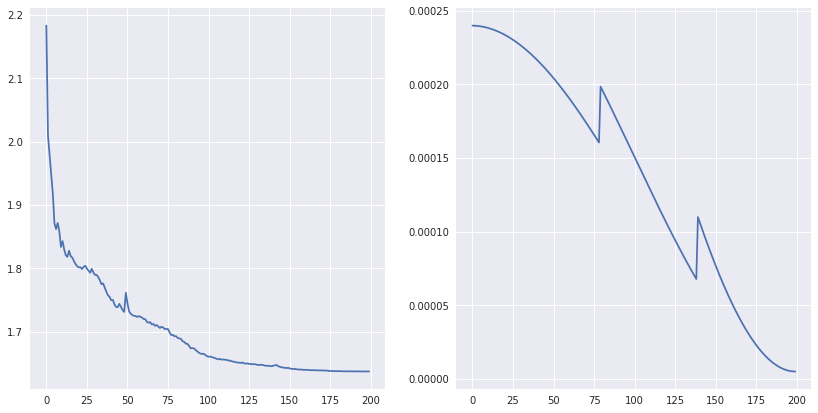

In [165]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2, figsize = (14,7))
sns.lineplot(ax= ax[0], x= range(len(loss_list)), y= loss_list)
sns.lineplot(ax= ax[1], x= range(len(lrs)), y= lrs)

In [196]:
def plot_confusion_matrix(conf_matrix, vmax = None):
    # labels = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
    plt.figure(figsize=(7,7))
    plt.imshow(conf_matrix, cmap='copper', interpolation='nearest',vmax = vmax)
    plt.colorbar()
    # plt.xticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    # plt.yticks(list(labels.keys()), [labels[i] for i in range(len(labels))])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10],[label_encoder.classes_[i] for i in range(len(label_encoder.classes_))],rotation=90)
    plt.yticks([0,1,2,3,4,5,6,7,8,9,10],[label_encoder.classes_[i] for i in range(len(label_encoder.classes_))])
    
    plt.xlabel('Predicted label',fontdict={"fontweight":"bold"})
    plt.ylabel('True label',fontdict={"fontweight":"bold"})
    plt.title('Confusion Matrix',fontdict={"fontsize":15,"fontweight":"bold"})
    plt.tight_layout()

/tmp/ipykernel_15618/3990516058.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


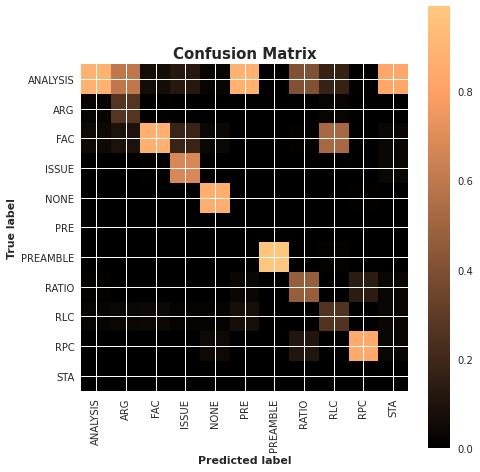

In [197]:
plot_confusion_matrix(np.divide(cm, np.sum(cm,axis=0)))

/tmp/ipykernel_15618/771531799.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


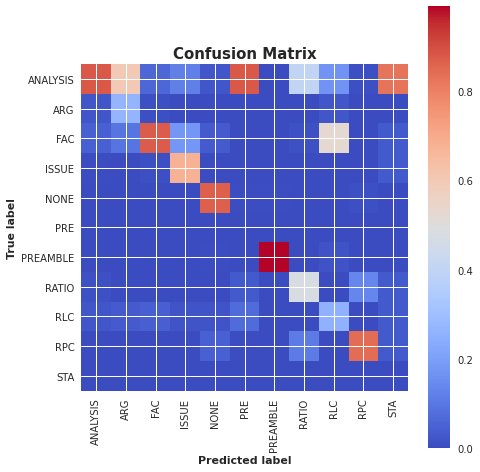

In [167]:
plot_confusion_matrix(np.divide(cm, np.sum(cm,axis=0)))